In [1]:
import matplotlib.pyplot as plt
import re
import pandas as pd

In [2]:
from collections import defaultdict

def parse_gamma_lines(lines):
    p = re.compile(r'Current gamma=(?P<gamma>0.[0-9]*) (?P<time>\d+)')
    res = defaultdict(list)
    for aline in lines:
        match=p.match(aline)
        if match:
            d = match.groupdict()
            gamma = float(d['gamma'])
            ts = int(d['time'])

            res[gamma].append(ts)
            
    return res
    
    
def parse_stream_step1(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()
    return {gamma: (t[1]-t[0]) for gamma, t in parse_gamma_lines(lines).items()}

    
def parse_stream_step3(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()
    # here we have 3 values (two phases) (merging and converting)
    merging= {gamma: (t[1]-t[0]) for gamma, t in parse_gamma_lines(lines).items()}
    converting = {gamma: (t[2]-t[1]) for gamma, t in parse_gamma_lines(lines).items()}
    return merging, converting


def totals(dicts):
    res = defaultdict(lambda: 0)
    for g in dicts[0].keys():
        for d in dicts:
            res[g]+=d[g]
    return res

In [3]:
stream_parts = [4, 6, 10, 16, 32]

In [4]:
stream_results = {}
for part in stream_parts:
    p1 =  parse_stream_step1(fname=f"../res/newestcluster/times/stream/part{part}/s1.out")
    p2 =  parse_stream_step1(fname=f"../res/newestcluster/times/stream/part{part}/s2.out")
    p3, p4 =  parse_stream_step3(fname=f"../res/newestcluster/times/stream/part{part}/s3.out")
    total = totals([p1, p2, p3, p4])
    
    stream_results[part] = [p1, p2, p3, p4, total]
    

In [14]:
merge_parts = [4, 6, 10, 16, 32]

merge_results = {}
for part in merge_parts:
    net_calc, convert =  parse_stream_step3(fname=f"../res/newestcluster/times/merge/part{part}/s1.out")
    merge =  parse_stream_step1(fname=f"../res/newestcluster/times/merge/part{part}/s2.out")

    total = totals([net_calc, convert, merge])
    
    merge_results[part] = [net_calc, convert, merge, total]

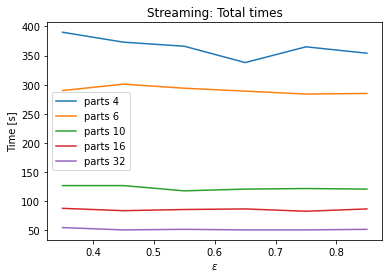

In [15]:
plt.title('Streaming: Total times')

for part, [p1, p2, p3, p4, total] in stream_results.items():
        plt.plot(total.keys(), total.values(), label=f"parts {part}")
        
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('Time [s]');
plt.savefig('../fig/times-streamed.svg', format='svg', bbox_inches = 'tight', dpi=1000);

In [16]:
def convert_to_epsilon(results, total_index=4):
    epsilon_results = {}
    for epsilon in results[6][0].keys():
        epsilon_results[epsilon] = {part:results[part][total_index][epsilon] for part in results.keys()}
        
    return epsilon_results
    

In [18]:
stream_epsilon = convert_to_epsilon(stream_results)

merge_epsilon = convert_to_epsilon(merge_results, total_index=3)

In [19]:
selected_eps = [0.35, 0.55, 0.85]

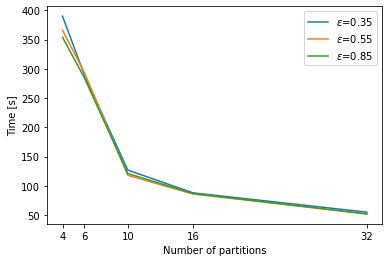

In [20]:
plt.xticks(stream_parts)

for epsilon, vals in stream_epsilon.items():
    if epsilon in selected_eps:
        plt.plot(vals.keys(), vals.values(), label=f"$\epsilon$={epsilon}")
    
plt.legend()
plt.xlabel("Number of partitions")
plt.ylabel("Time [s]");

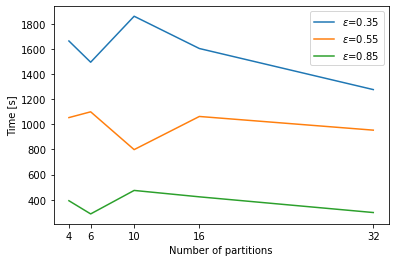

In [21]:
plt.xticks(stream_parts)

for epsilon, vals in merge_epsilon.items():
    if epsilon not in selected_eps:
        continue
    plt.plot(vals.keys(), vals.values(), label=f"$\epsilon$={epsilon}")
    
plt.legend()
plt.xlabel("Number of partitions")
plt.ylabel("Time [s]");

In [12]:
def plot_part(part):
    [net_calc, net_update, merge, convert, total] = part
    
    plt.plot(net_calc.keys(), net_calc.values(), label='Network cration')
    plt.plot(net_update.keys(), net_update.values(), label='Network update')
    plt.plot(merge.keys(), merge.values(), label='Merging')
    plt.plot(convert.keys(), convert.values(), label='Converting')
    
    plt.plot(total.keys(), total.values(), label='Total')
    
    plt.legend()
    plt.xlabel('$\epsilon$')
    plt.ylabel('Time [s]');

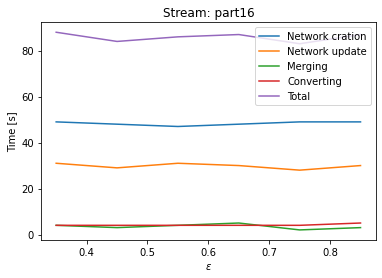

In [13]:
plt.title('Stream: part16')
plot_part(stream_results[16])

In [22]:
def plot_barpart(part):
    plt.xticks(list(part[0].keys()))
    [net_calc, net_update, merge, convert, total] = part
    width = 0.05
    plt.bar(net_calc.keys(), net_calc.values(),width=width, label='Network creation', color='orange')
    plt.bar(net_update.keys(), net_update.values(), width, label='Distribution update*')
    plt.bar(merge.keys(), merge.values(), width, label='Merging', color='lightblue')
    #plt.bar(convert.keys(), convert.values(),width,  label='Converting')
    
    #plt.plot(total.keys(), total.values(), label='Total')
    plt.ylim(0,100)
    plt.legend()
    plt.xlabel('$\epsilon$')
    plt.ylabel('Time [s]');

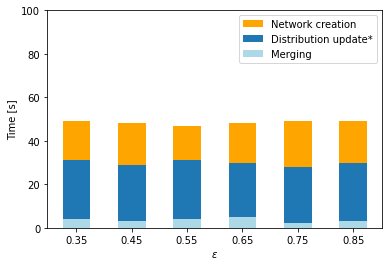

In [23]:
plot_barpart(stream_results[16])

## Merge

In [16]:
! ls ../res/newestcluster/times/merge/

part10	part16	part32	part4  part6


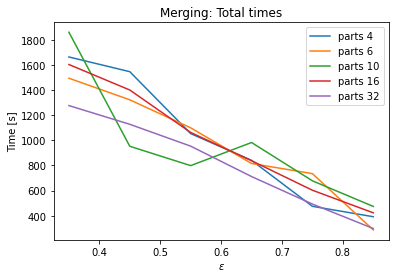

In [24]:
plt.title('Merging: Total times')

for part, [net_calc, convert, merge, total] in merge_results.items():
        plt.plot(total.keys(), total.values(), label=f"parts {part}")
        
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('Time [s]');
plt.savefig('../fig/times-streamed.svg', format='svg', bbox_inches = 'tight', dpi=1000);

In [25]:
def plot_merge_part(part):
    [net_calc, convert, merge, total] = part
    
    plt.plot(net_calc.keys(), net_calc.values(), label='Network creation')
    plt.plot(convert.keys(), convert.values(), label='Conversion')
    plt.plot(merge.keys(), merge.values(), label='Merging')
    
    
    plt.plot(total.keys(), total.values(), label='Total')
    
    plt.legend()
    plt.xlabel('$\epsilon$')
    plt.ylabel('Time [s]');
    
    
def plot_barpart2(part):
    plt.xticks(list(part[0].keys()))
    [net_calc, convert, merge, total] = part
    width = 0.05
    #plt.bar(convert.keys(), convert.values(), width, label='Network update')
    plt.bar(merge.keys(), merge.values(), width, label='Merging', color='lightblue')
    plt.bar(net_calc.keys(), net_calc.values(),width=width, label='Network creation', color='orange')
    

    
    plt.legend()
    plt.xlabel('$\epsilon$')
    plt.ylabel('Time [s]');

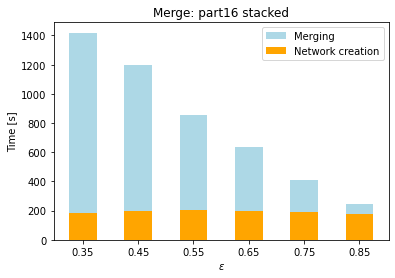

In [26]:
plt.title('Merge: part16 stacked')
plot_barpart2(merge_results[16])

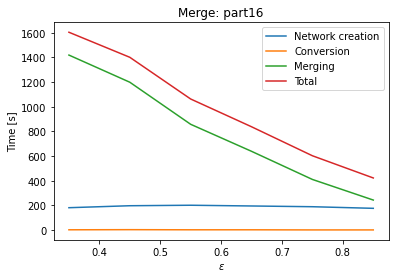

In [27]:
plt.title('Merge: part16')
plot_merge_part(merge_results[16])


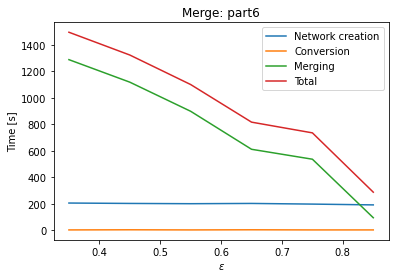

In [28]:
plt.title('Merge: part6')
plot_merge_part(merge_results[6])

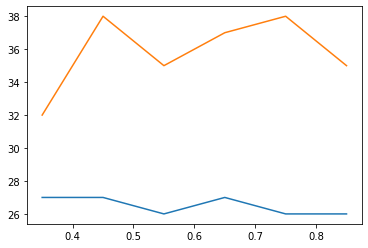

In [31]:
plt.plot(snet_calc.keys(), snet_calc.values())
plt.plot(net_calc.keys(), net_calc.values())

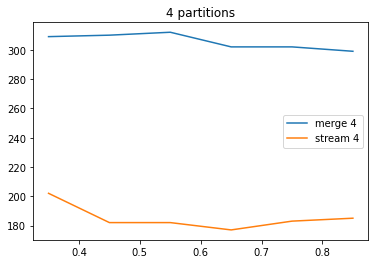

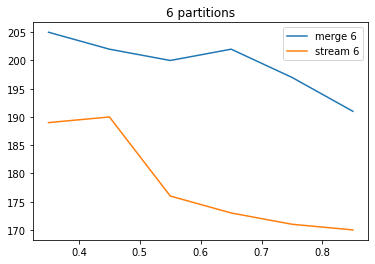

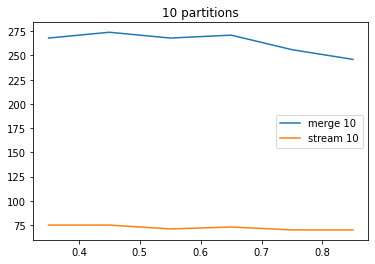

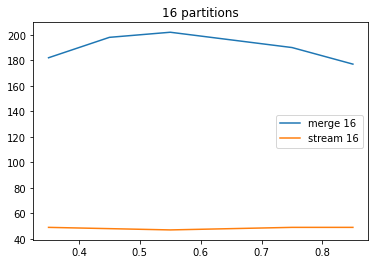

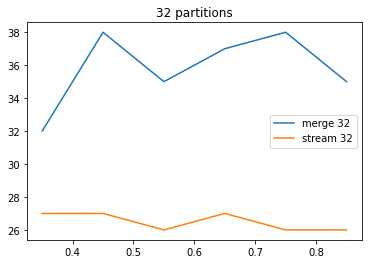

In [30]:
for s in merge_parts:
    [net_calc, convert, merge, total] = merge_results[s]
    [snet_calc, snet_update, smerge, sconvert, stotal] = stream_results[s]
    
    plt.figure(s)
    plt.title(f"{s} partitions")
    plt.plot(net_calc.keys(), net_calc.values(), label=f"merge {s}")
    plt.plot(snet_calc.keys(), snet_calc.values(), label=f"stream {s}")
    plt.legend()

## Reference times

In [33]:
def read_ref_times(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()

    res = defaultdict(list)
    for a in [l for l in lines if l.startswith('Curr')]:

        result = re.findall(r"\d*\.\d+|\d+", a)
        gamma, ts = float(result[0]), int(result[1])
        res[gamma].append(ts)
    
    return res

In [34]:
ref1 = read_ref_times(fname='../res/reft/reftime1.out')
ref2 = read_ref_times(fname='../res/reft/reftime2.out')

In [35]:
df = pd.DataFrame.from_dict(ref1, orient='index')

df['Creation'] = df[1] - df[0]
df['Conversion'] = df[2] -df[1]

df.drop(columns=[0,1,2], inplace=True)

## Reference creation times (non-distributed)

In [36]:
df

,Creation,Conversion
0.35,742,5
0.45,758,5
0.55,746,6
0.65,741,5
0.75,742,6
0.85,735,5


In [37]:
df.Creation.mean()

744.0

In [38]:
m={4: 390, 6: 290, 10: 127, 16: 88, 32: 55}

In [39]:
m[1]=df.loc[0.35].Creation

In [70]:
for k, dats in stream_epsilon.items():
    dats[1]= df.loc[k].Creation

In [71]:
dict(sorted(stream_epsilon[0.35].items()))

{1: 742, 4: 390, 6: 290, 10: 127, 16: 88, 32: 55}

In [56]:
for k, dats in stream_epsilon.items():
    del dats[1]

## Figure 11 in paper (Streamed creation times now with reference)

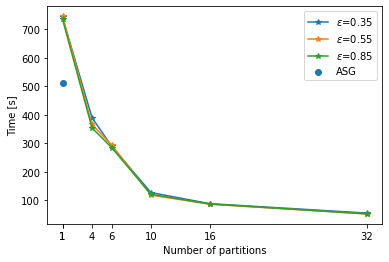

In [72]:
#plt.figure(figsize=(10,8))
plt.xticks([1]+ list( stream_epsilon[0.35].keys()))

for epsilon, vals in stream_epsilon.items():
    if epsilon in selected_eps:
        vals = dict(sorted(vals.items()))
        plt.plot(vals.keys(), vals.values(),'-*', label=f"$\epsilon$={epsilon}")

plt.scatter(1, 510, label='ASG') 
plt.legend()
plt.xlabel("Number of partitions")
plt.ylabel("Time [s]");
plt.savefig('../fig/fig11.svg', format='svg', bbox_inches = 'tight', dpi=1000);

## Figure 12 in paper (Merged creation times, now with reference)

In [67]:
for k, dats in merge_epsilon.items():
    dats[1]= df.loc[k].Creation

In [61]:
for k, dats in merge_epsilon.items():
    del dats[1]

KeyError: 1

In [68]:
merge_epsilon

{0.35: {4: 1664, 6: 1495, 10: 1861, 16: 1604, 32: 1277, 1: 742},
 0.45: {4: 1547, 6: 1323, 10: 953, 16: 1401, 32: 1128, 1: 758},
 0.55: {4: 1054, 6: 1100, 10: 799, 16: 1063, 32: 954, 1: 746},
 0.65: {4: 841, 6: 816, 10: 983, 16: 838, 32: 712, 1: 741},
 0.75: {4: 475, 6: 735, 10: 678, 16: 603, 32: 493, 1: 742},
 0.85: {4: 392, 6: 287, 10: 474, 16: 423, 32: 298, 1: 735}}

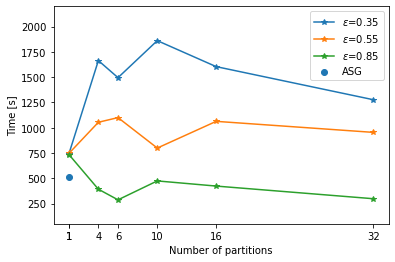

In [69]:
#plt.figure(figsize=(10,8))
plt.xticks([1]+list(merge_epsilon[0.35].keys()))

for epsilon, vals in merge_epsilon.items():
    if epsilon not in selected_eps:
        continue
    vals = dict(sorted(vals.items()))
    plt.plot(vals.keys(), vals.values(),'-*', label=f"$\epsilon$={epsilon}")

#plt.axhline(df.Creation.mean(), ls='--', label='Non-distributed (mean)') 
plt.scatter(1, 510, label='ASG') 
plt.ylim(50, 2200)
plt.legend()
plt.xlabel("Number of partitions")
plt.ylabel("Time [s]");

plt.savefig('../fig/fig12.svg', format='svg', bbox_inches = 'tight', dpi=1000);

## Bart plots

In [40]:
import numpy as np

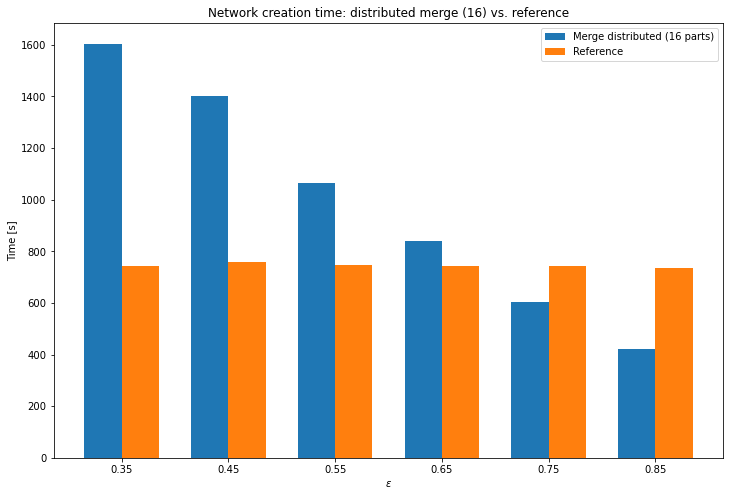

In [41]:
num_parts = 16
fig, ax = plt.subplots(figsize=(12, 8))
plt.title(f"Network creation time: distributed merge ({num_parts}) vs. reference")
[net_calc, convert, merge, total] = merge_results[num_parts]

x = np.arange(len(merge.keys()))
width = 0.35

rects1 = ax.bar(x - width / 2, total.values(), width, label=f"Merge distributed ({num_parts} parts)")
rects2 = ax.bar(x + width / 2, df.Creation.values, width, label='Reference')

plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('Time [s]');
ax.set_xticks(x, merge.keys());

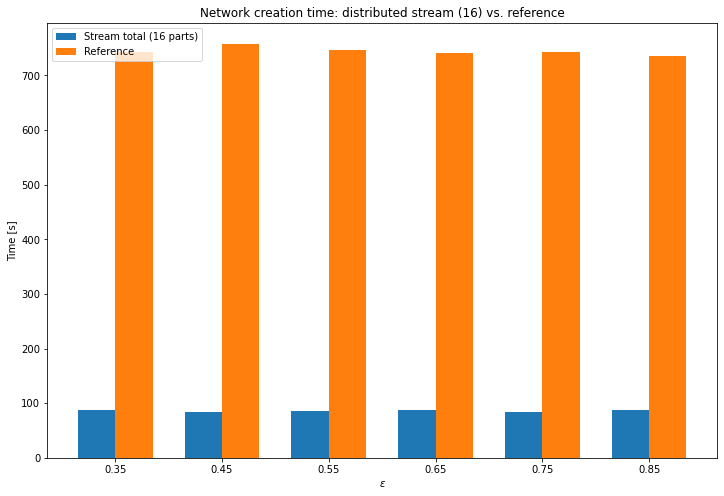

In [42]:
num_parts = 16
fig, ax = plt.subplots(figsize=(12, 8))
plt.title(f"Network creation time: distributed stream ({num_parts}) vs. reference")

[net_calc, net_update, merge, convert, total] = stream_results[16]

x = np.arange(len(total.keys()))
width = 0.35


rects1 = ax.bar(x - width / 2, total.values(), width, label=f"Stream total ({num_parts} parts)")
rects2 = ax.bar(x + width / 2, df.Creation.values, width, label='Reference')

plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('Time [s]');
ax.set_xticks(x, merge.keys());

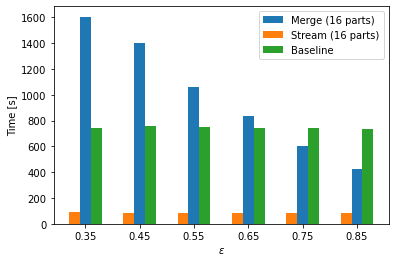

In [54]:
num_parts = 16
fig, ax = plt.subplots()
#plt.title(f"Network creation time: distributed stream ({num_parts}) vs. reference")

[net_calc, net_update, merge, convert, total_stream] = stream_results[16]
[_, _ ,_, total_merge] = merge_results[16]
x = np.arange(len(total.keys()))
width = 0.60


rects2 = ax.bar(x , total_merge.values(), width/3, label=f"Merge ({num_parts} parts)")

rects1 = ax.bar(x - width / 3, total_stream.values(), width/3, label=f"Stream ({num_parts} parts)")
rects3 = ax.bar(x + width / 3, df.Creation.values, width/3, label='Baseline')

plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('Time [s]');
ax.set_xticks(x, merge.keys());
plt.savefig('../fig/fig18.svg', format='svg', bbox_inches = 'tight', dpi=1000);

In [ ]:
- base line not reference
(ASGnn from the paper)


In [ ]:
fda